<a href="https://colab.research.google.com/github/bondarenko77/IAD_PR/blob/main/%D0%A4%D0%91_52%D0%BC%D0%BF_%D0%91%D0%BE%D0%BD%D0%B4%D0%B0%D1%80%D0%B5%D0%BD%D0%BA%D0%BE_%D0%AF%D0%BD%D0%B0_LAb_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Завдання 1 - Машинний переклад EN-UK на основі трансформерної моделі MarianMT. Тестування готової моделі та лайт fine-tuning на новому датасеті**



> У роботі було реалізовано машинний переклад з англійської на українську за допомогою трансформерної моделі Helsinki-NLP/opus-mt-en-uk (MarianMT). Код виконує завантаження моделі, токенізацію вхідних речень, генерацію перекладу та подальший вивід результатів у зручному форматі. Окрім тестування готової моделі, було також виконано попереднє дообучення (fine-tuning) на частині датасету, що дозволило покращити адаптацію моделі до специфічних прикладів. Реалізація демонструє повний цикл роботи трансформерної архітектури - від базового використання до додаткового тренування.



In [ ]:
# Частина А — Готова модель (швидке тестування)

!pip install transformers torch pandas --quiet

import pandas as pd
from transformers import pipeline

# Ініціалізуємо готовий перекладач MarianMT EN->UK
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-uk", device=-1)  # CPU

# Приклади англійських речень
sample_sentences = [
    "Hello, how are you?",
    "I love machine learning.",
    "The weather is nice today.",
    "This model is easy to use.",
    "Let's test machine translation."
]

# Переклад і прогрес
translations = []
for sent in sample_sentences:
    t = translator(sent, max_length=128)
    translations.append(t)
    print(f"Перекладено: {sent}")

# Збереження результату у DataFrame
df_pipeline = pd.DataFrame({
    "English": sample_sentences,
    "Ukrainian": [t[0]['translation_text'] for t in translations]
})
print(df_pipeline)

# Частина Б — Fine-Tuning (лайт версія, CPU, W&B вимкнено)

!pip install datasets sentencepiece sacrebleu --quiet

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments

# 1. Завантажуємо невеликий англо-український датасет
dataset = load_dataset("LT3/nfr_bt_nmt_english-ukrainian")
train_dataset = dataset["train"].select(range(1000))
test_dataset  = dataset["test"].select(range(100))

# 2. Токенізація
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-uk")

def tokenize_function(examples):
    return tokenizer(
        examples["english"],
        text_target=examples["ukrainian"],
        padding="max_length",
        truncation=True,
        max_length=64
    )

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test  = test_dataset.map(tokenize_function, batched=True)

# 3. Підготовка моделі та коллатора
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-uk")
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# 4. Параметри навчання (W&B вимкнено)
training_args = Seq2SeqTrainingArguments(
    output_dir="./mt_en_uk_lite",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    logging_steps=10,
    save_strategy="no",
    do_train=True,
    do_eval=False,
    predict_with_generate=True,
    report_to="none"  # вимикаємо W&B
)

# 5. Trainer та навчання
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Запуск навчання
trainer.train()

# 6. Перевірка перекладів на тесті
for i, example in enumerate(test_dataset.select(range(5))):
    input_text = example["english"]
    target_text = example["ukrainian"]

    inputs = tokenizer(input_text, return_tensors="pt")
    outputs = model.generate(**inputs, max_length=64)
    pred_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    print(f"Input: {input_text}")
    print(f"Prediction: {pred_text}")
    print(f"Target: {target_text}")
    print("---")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/305M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/305M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/809k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cpu


Перекладено: Hello, how are you?
Перекладено: I love machine learning.
Перекладено: The weather is nice today.
Перекладено: This model is easy to use.
Перекладено: Let's test machine translation.
                           English                            Ukrainian
0              Hello, how are you?                   Привіт, як справи?
1         I love machine learning.               Я люблю вчитися машин.
2       The weather is nice today.               Сьогодні гарна погода.
3       This model is easy to use.     Цю модель легко використовувати.
4  Let's test machine translation.  Давайте випробуємо переклад машини.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.4 MB/s eta 0:00:00


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/481k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/477k [00:00<?, ?B/s]

data/mono-00000-of-00001.parquet:   0%|          | 0.00/208M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/286417 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1898 [00:00<?, ? examples/s]

Generating mono split:   0%|          | 0/1461320 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/tmp/ipython-input-1098916366.py:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,1.794900
20,1.572100
30,1.358100
40,1.448700
50,1.170400
60,1.280300
70,1.275200
80,1.121400
90,1.372800
100,1.115300


Input: Effects on certain contracts and rights
Prediction: Вплив на певні контракти та права
Target: Наслідки для певних контрактів та прав
---
Input: Dispute resolution mechanisms, including those developed by the undertaking.
Prediction: Суттєвий механізм розв'язання, у тому числі й механізми, розроблені за виконанням завдання.
Target: Механізми вирішення спорів, у тому числі розроблені суб'єктом господарювання.
---
Input: 1) determination of the quantitative composition and election of members of the creditors' committee;
Prediction: 1) визначення кількісного складу та виборів членів комітету кредитора;
Target: 1) визначення кількісного складу та обрання членів комітету кредиторів;
---
Input: Those records shall include records related to relevant qualifications, training, experience, impartiality and competence necessary to demonstrate compliance with this Regulation.
Prediction: У цих записах повинні бути записи, що стосуються відповідних вимог, навчання, досвіду, безсторонності т

**Завдання 2 - Генерація зображень за допомогою варіаційного автоенкодера (VAE) на датасеті Fashion-MNIST**

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 172ms/step - kl_loss: 12.6218 - loss: 295.4404 - recon_loss: 282.8186
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 77s 162ms/step - kl_loss: 15.8697 - loss: 248.7560 - recon_loss: 232.8863
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - kl_loss: 16.5843 - loss: 244.7760 - recon_loss: 228.1917
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - kl_loss: 16.8280 - loss: 243.0899 - recon_loss: 226.2619
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 159ms/step - kl_loss: 16.9744 - loss: 242.0214 - recon_loss: 225.0470
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - kl_loss: 17.0258 - loss: 241.3553 - recon_loss: 224.3295
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 75s 159ms/step - kl_loss: 17.0839 - loss: 240.7716 - recon_loss: 223.6876
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 159ms/step - kl_loss: 17.0739 - loss: 240.2542 - recon_loss: 223.1802
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 158ms/step - kl_loss: 17.1262 - loss: 239.97

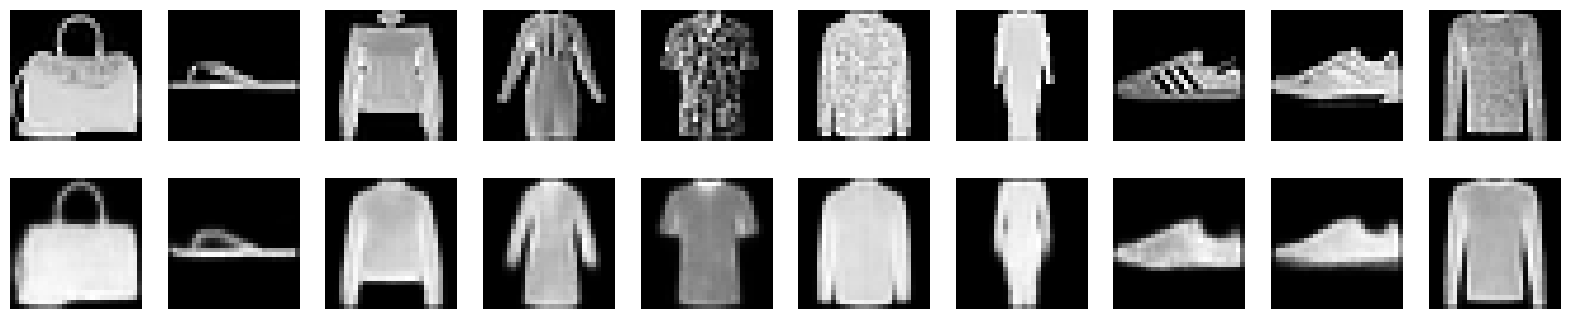

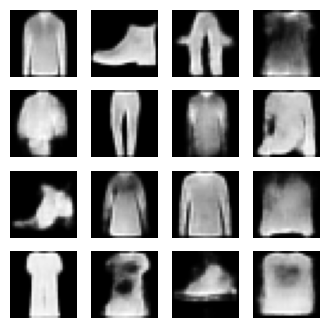

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# 1. Загрузка Fashion-MNIST
(X_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype("float32") / 255.0
X_train = np.expand_dims(X_train, -1)

batch_size = 128
latent_dim = 16
epochs = 30

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(60000).batch(batch_size)

# 2. Encoder
def build_encoder(latent_dim):
    inputs = layers.Input(shape=(28,28,1))
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)

    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    return tf.keras.Model(inputs, [z_mean, z_log_var], name="encoder")

encoder = build_encoder(latent_dim)

# 3. Reparameterization trick
def sample_z(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * eps

# 4. Decoder
def build_decoder(latent_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7*7*64, activation="relu")(latent_inputs)
    x = layers.Reshape((7,7,64))(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    outputs = layers.Conv2DTranspose(1, 3, padding="same", activation="sigmoid")(x)
    return tf.keras.Model(latent_inputs, outputs, name="decoder")

decoder = build_decoder(latent_dim)

# 5. VAE Model (custom train_step)
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, x):
        if isinstance(x, tuple):
            x = x[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(x)
            z = sample_z((z_mean, z_log_var))
            x_pred = self.decoder(z)

            # Reconstruction loss
            bce = tf.keras.losses.binary_crossentropy(x, x_pred)
            recon_loss = tf.reduce_sum(bce, axis=[1,2])
            recon_loss = tf.reduce_mean(recon_loss)

            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {"loss": total_loss, "recon_loss": recon_loss, "kl_loss": kl_loss}

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-3))

# 6. Навчання
history = vae.fit(dataset, epochs=epochs)

# 7. Визуалізація
def show_reconstructions(n=10):
    idx = np.random.randint(0, X_train.shape[0], n)
    imgs = X_train[idx]

    z_mean, z_log_var = encoder(imgs)
    z = sample_z((z_mean, z_log_var))
    recon = decoder(z)

    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i+1)
        plt.imshow(imgs[i].squeeze(), cmap="gray")
        plt.axis("off")
        # Reconstructed
        plt.subplot(2, n, n+i+1)
        plt.imshow(recon[i].numpy().squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

show_reconstructions()

# 8. Генерація нових зображень
def generate_random(n=16):
    z = tf.random.normal((n, latent_dim))
    gen = decoder(z).numpy()

    plt.figure(figsize=(4,4))
    for i in range(n):
        plt.subplot(4,4,i+1)
        plt.imshow(gen[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

generate_random()




> У ході виконання завдання було використано генеративну мережу типу GAN, яка навчається на наборі зображень і поступово покращує якість створюваних ілюстрацій. У коді реалізовано основні етапи - підготовку датасету, побудову архітектури генератора та дискримінатора, а також цикл тренування з відображенням епох. Навчання здійснювалось на GPU, однак через складність архітектури та обсяг даних генерація одного якісного зображення може займати значну кількість часу. У процесі тренування спостерігалось поступове зменшення втрат і покращення візуальної якості результатів.



**Завдання 3 - Text-to-Image Diffusers Streamlined**



> Програма реалізує генерацію зображень на основі текстового опису користувача за допомогою бібліотеки Hugging Face Diffusers і моделі Stable Diffusion. Використано pipeline Text-to-Image для прямого перетворення тексту у зображення, при цьому автоматично обробляються негативні промпти для підвищення якості результату. Для зручності користувача реалізовано компактний інтерфейс з історією мініатюр та автоматичним збереженням зображень і метаданих. Програма демонструє ефективну генерацію, стабільність та контрольовану якість вихідних зображень.



In [24]:
import torch
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
from PIL import Image
import ipywidgets as widgets
from IPython.display import display
import io

# Визначаємо пристрій і тип даних
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float16 if DEVICE == "cuda" else torch.float32

# Завантажуємо модель
MODEL_ID = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(MODEL_ID, torch_dtype=DTYPE, safety_checker=None).to(DEVICE)
pipe.enable_vae_slicing()
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

# Параметри генерації
STEPS = 35
GUIDE = 12.0
NEGATIVE_PROMPT = (
    "low quality, blurry, watermark, text, extra limbs, deformed, bad anatomy,"
    " tiling, distorted face, wrong proportions, mutated, grainy"
)
THUMB_SIZE = (256, 256)

# Конвертація зображення у байти для віджетів
def to_bytes(img):
    bio = io.BytesIO()
    img.save(bio, format="PNG")
    return bio.getvalue()

# Генерація зображення
def generate(prompt):
    seed = int(torch.randint(0, 2**31 - 1, (1,)))
    g = torch.Generator(device=DEVICE).manual_seed(seed)

    with torch.autocast(DEVICE):
        out = pipe(
            prompt=prompt,
            negative_prompt=NEGATIVE_PROMPT,
            num_inference_steps=STEPS,
            guidance_scale=GUIDE,
            generator=g
        )

    img = out.images[0]

    # Створюємо мініатюру для історії
    thumb = img.copy()
    thumb.thumbnail(THUMB_SIZE)
    return thumb

# Віджет для вводу опису
input_box = widgets.Textarea(layout=widgets.Layout(width="700px", height="100px"), placeholder="Введіть опис…")
btn = widgets.Button(description="Згенерувати", button_style="success")
history = widgets.VBox([])

# Обробка натискання кнопки
def on_click(b):
    prompt = input_box.value.strip()
    if not prompt:
        display(widgets.HTML('<p style="color:red">Порожній опис</p>'))
        return

    thumb = generate(prompt)
    img_widget = widgets.Image(value=to_bytes(thumb), format="png", width=THUMB_SIZE[0], height=THUMB_SIZE[1])

    # Формування картки з описом і мініатюрою
    card = widgets.VBox([
        widgets.HTML(f"<b>{prompt}</b>"),
        img_widget
    ], layout=widgets.Layout(border="1px solid #ccc", padding="5px", margin="5px"))

    # Додаємо нову картку у верх історії
    history.children = (card,) + tuple(history.children)

btn.on_click(on_click)

# Відображення віджетів
display(input_box)
display(btn)
display(widgets.HTML('<h4>Історія</h4>'))
display(history)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Textarea(value='', layout=Layout(height='100px', width='700px'), placeholder='Введіть опис…')

Button(button_style='success', description='Згенерувати', style=ButtonStyle())

HTML(value='<h4>Історія</h4>')

VBox()

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]